In [1]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD


In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [5]:
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

def resize_load_img(path_to_img, target_shape):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, target_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

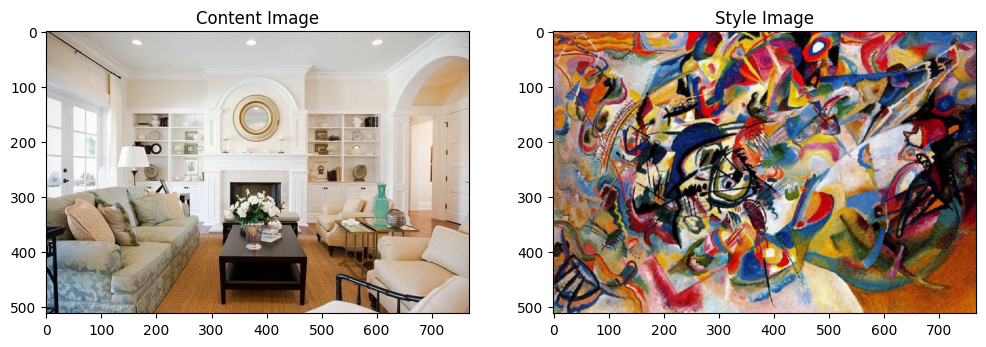

In [6]:
original_image_path = 'ADE_val_00001519.jpg'
original_image = load_img(original_image_path)
content_image = resize_load_img(original_image_path, (original_image.shape[0], original_image.shape[1]))

style_image = resize_load_img(style_path, (original_image.shape[0], original_image.shape[1]))

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

assert content_image.shape == style_image.shape

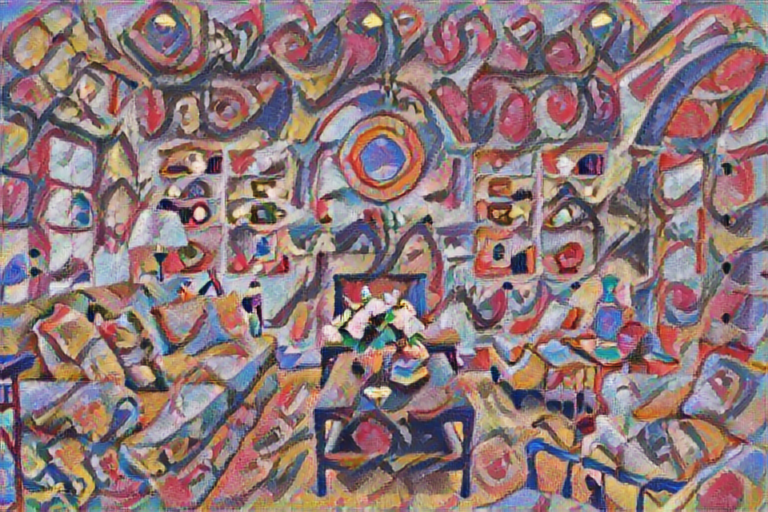

In [7]:
import tensorflow_hub as hub
import cv2
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [8]:
stylized_img = (stylized_image.numpy()[0] * 255).astype(np.uint8)
stylized_img = cv2.cvtColor(stylized_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("kandinsky5_stylized_img.png", stylized_img)

True

In [9]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

In [10]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [11]:
def get_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.array(pred_color)
    # display(PIL.Image.fromarray(im_vis))
    plt.figure(figsize=(10, 10))
    plt.imshow(im_vis)
    plt.axis('off')
    plt.show()
    return im_vis

In [12]:
def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    plt.figure(figsize=(10, 10))
    plt.imshow(pred_color)
    plt.axis('off')
    plt.show()

    return pred_color

sofa:


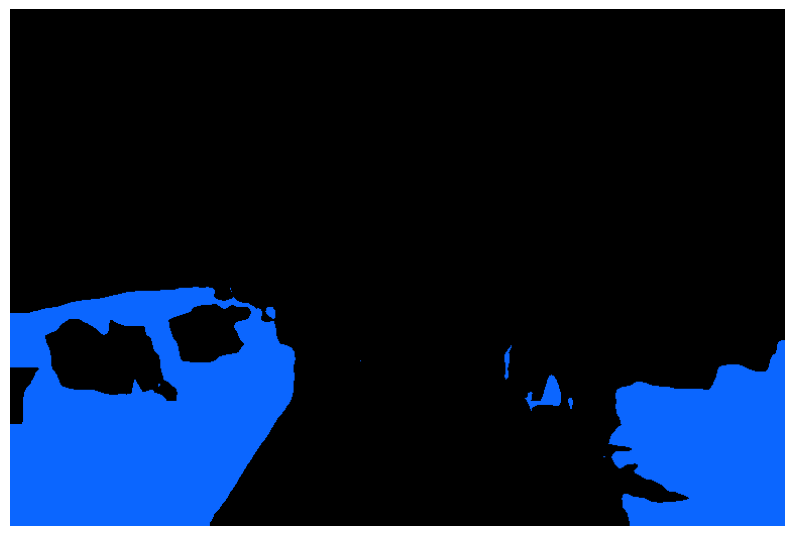

In [13]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('ADE_val_00001519.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()


sofa = get_result(img_original, pred, 23)
sofa_location = []
for x in range(sofa.shape[0]):
    for y in range(sofa.shape[1]):
        if (sofa[x][y] !=[0, 0, 0]).any():
            sofa_location.append((x, y))

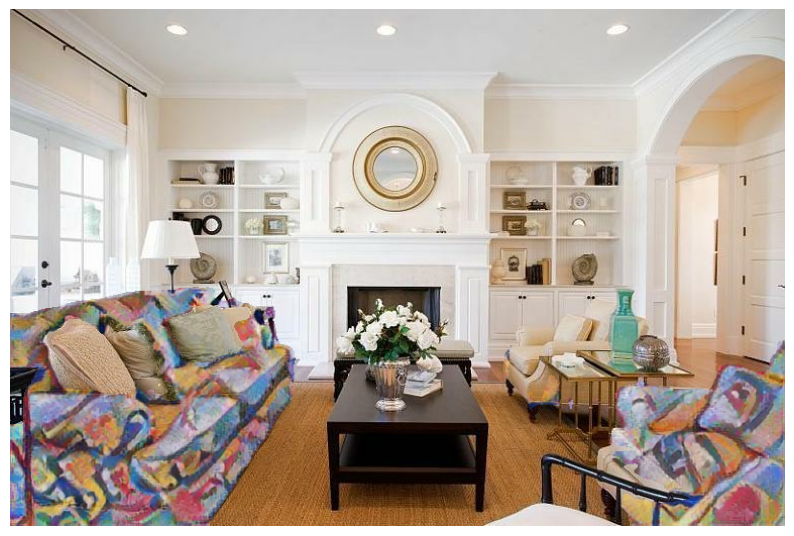

In [14]:
import matplotlib.pyplot as plt

newImage = content_image.numpy()[0].copy()
for (x, y) in sofa_location:
  newImage[x][y] = stylized_image.numpy()[0][x][y]

plt.figure(figsize=(10, 10))
plt.imshow(newImage)
plt.axis('off')
plt.show()

In [15]:
import cv2
import numpy as np
img = (newImage * 255).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("stylized_sofa.png", img)

True

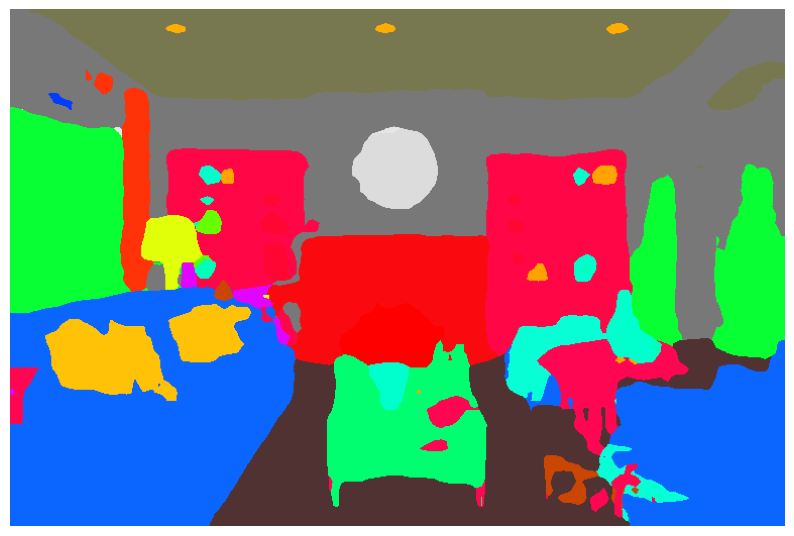

True

In [16]:
seg_pred = visualize_result(img_original, pred)

seg_pred = seg_pred.astype(np.uint8)
cv2.imwrite("seg_pred.png", pred)

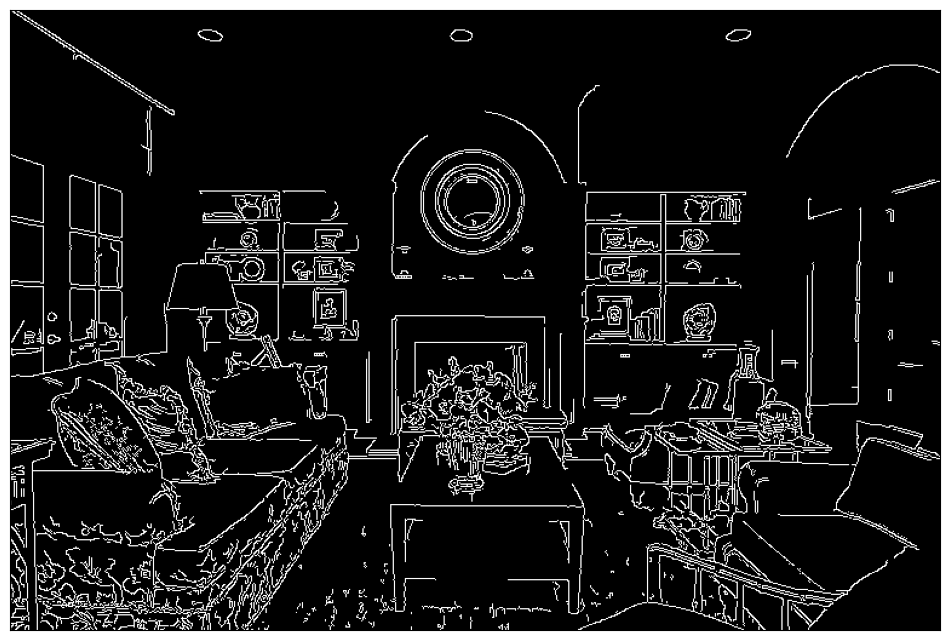

In [17]:
import cv2
import matplotlib.pyplot as plt

def get_edges(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 100, 200)
    # print(edges)

    plt.imshow(edges, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return edges

edges = get_edges('ADE_val_00001519.jpg')

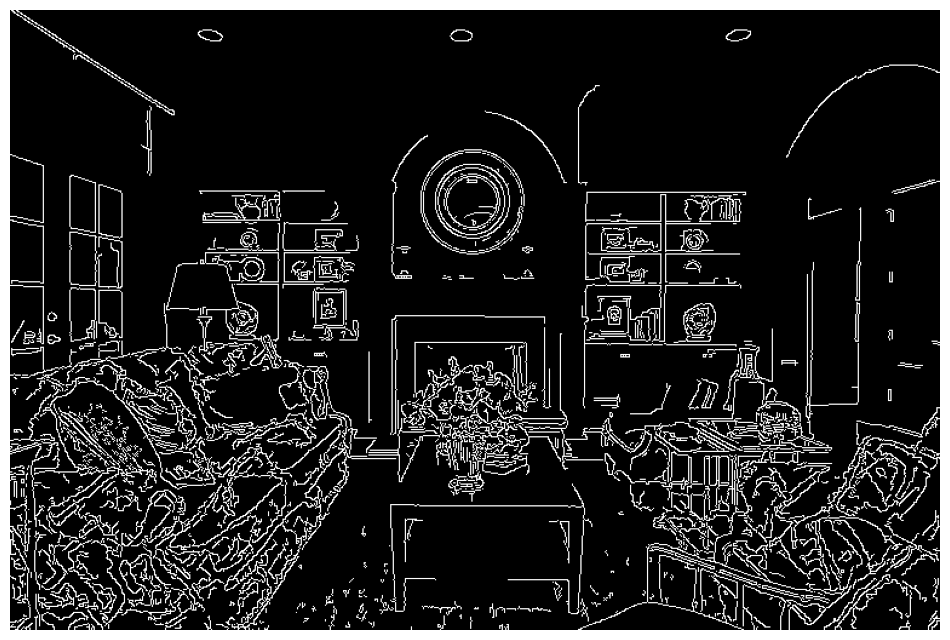

In [18]:
def analyze_edges(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 100, 200)
    # print(edges)

    plt.imshow(edges, cmap='gray')
    plt.axis("off")

analyze_edges('stylized_sofa.png')

In [19]:
newImage_copy = newImage.copy()

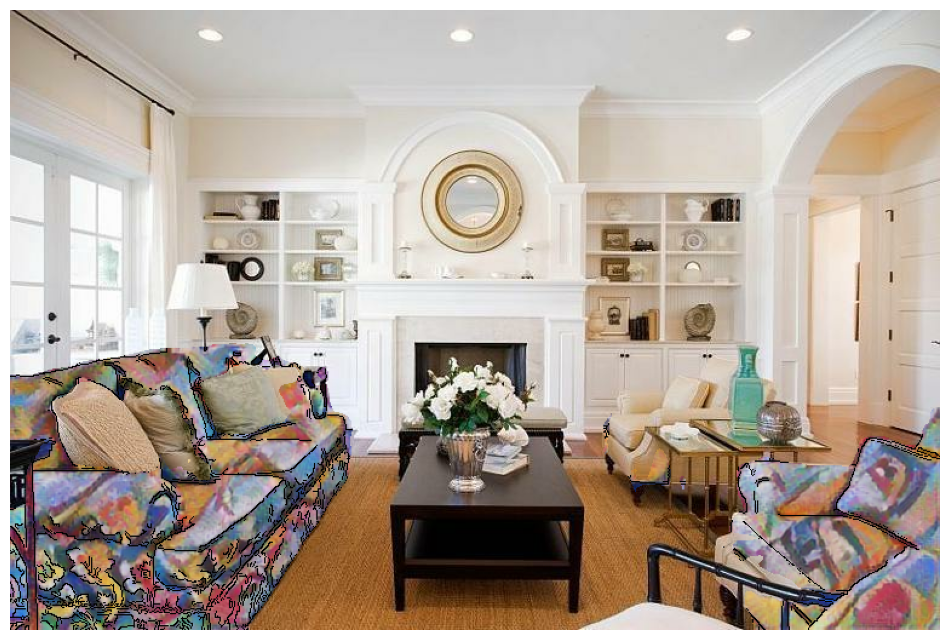

In [20]:
for (x, y) in sofa_location:
    if edges[x][y] == 255:
        newImage_copy[x][y] = [0, 0, 0]

plt.imshow(newImage_copy)
plt.axis('off')
plt.show()

In [21]:
min_x, min_y = np.inf, np.inf
max_x, max_y = 0, 0
for (x, y) in sofa_location:
  if x < min_x:
    min_x = x
  if y < min_y:
    min_y = y
  if x > max_x:
    max_x = x
  if y > max_y:
    max_y = y

print(min_x, max_x, min_y, max_y)

275 511 0 767


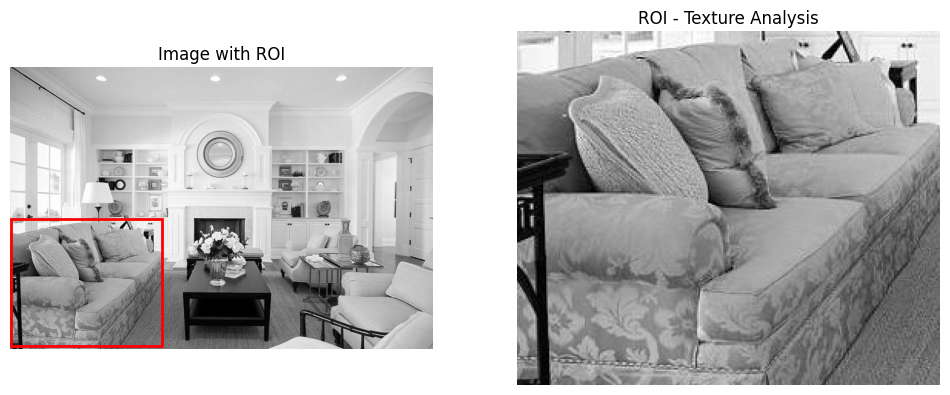

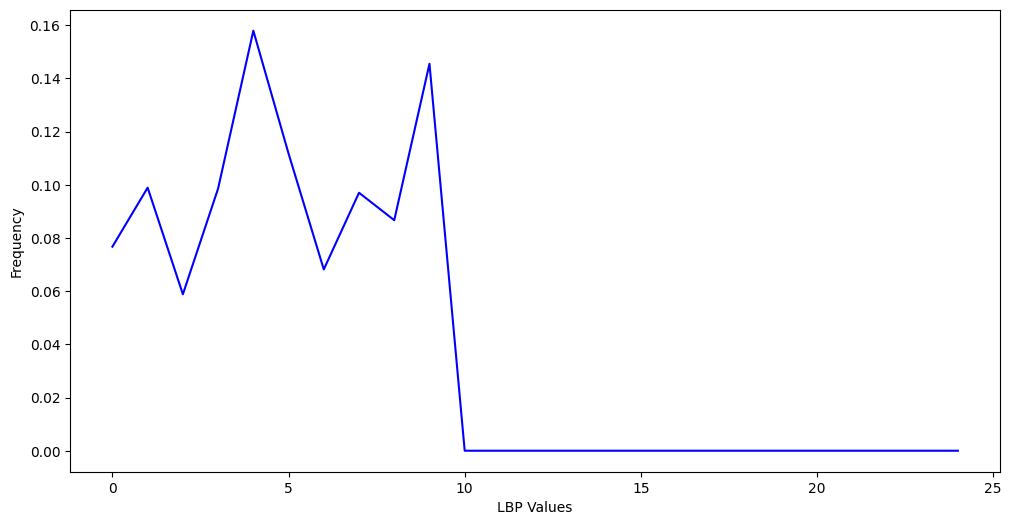

Original Image Texture Features:
{'Contrast': 1328.2148148148149, 'Dissimilarity': 21.444508856682766, 'Homogeneity': 0.09195909808753856, 'Energy': 0.012333813640466195, 'Correlation': 0.6965174133986551, 'LBP Histogram': array([0.07672727, 0.09890909, 0.05881423, 0.09859289, 0.15791304,
       0.11171542, 0.06817391, 0.09699605, 0.08667194, 0.14548617,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])}


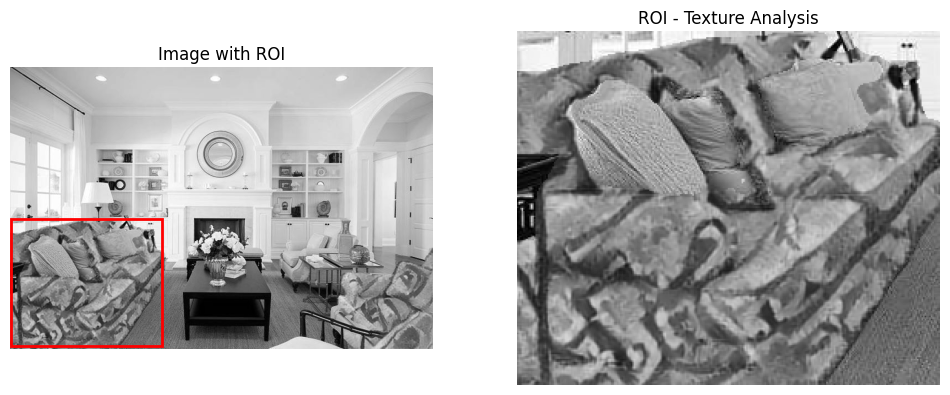

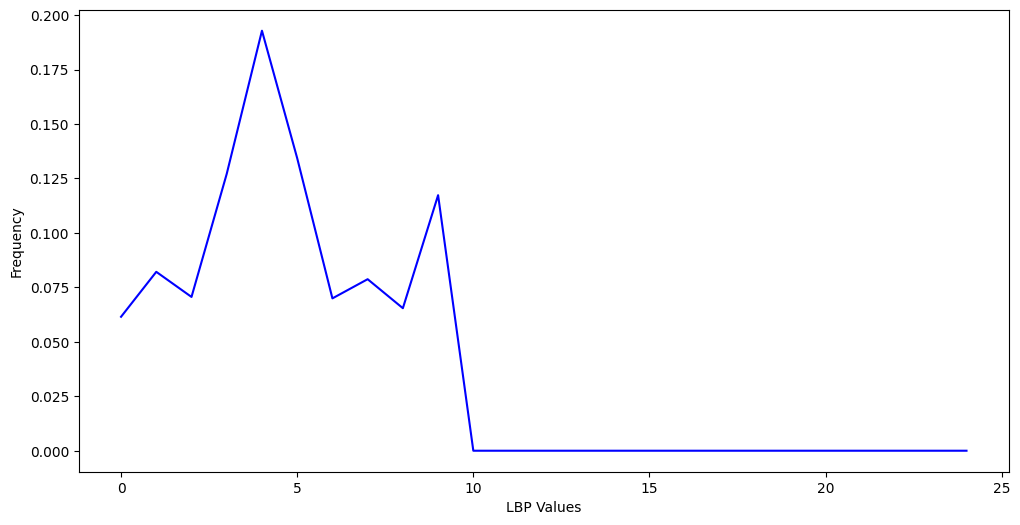

Altered Image Texture Features:
{'Contrast': 1772.0370531400963, 'Dissimilarity': 29.10233494363929, 'Homogeneity': 0.054715480818600934, 'Energy': 0.00851219214168765, 'Correlation': 0.5855618818362408, 'LBP Histogram': array([0.06150198, 0.08213439, 0.0706087 , 0.12713043, 0.19283794,
       0.13432411, 0.06994466, 0.07875099, 0.06543874, 0.11732806,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])}


In [22]:
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage import io, color
import matplotlib.patches as patches
import cv2
import numpy as np

def analyze_texture(image_path, coordinates):
    # Load the image
    img = io.imread(image_path)
    img_gray = color.rgb2gray(img)

    # Extract the Region of Interest (ROI)
    x, y, w, h = coordinates
    roi = img_gray[y:y+h, x:x+w]

    # Compute GLCM and texture properties
    glcm = graycomatrix((roi * 255).astype('uint8'), distances=[5], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Compute Local Binary Pattern
    lbp = local_binary_pattern(roi, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 26), range=(0, 26), density=True)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_gray, cmap='gray')
    # Highlight the ROI
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Image with ROI')
    ax[0].axis('off')

    ax[1].imshow(roi, cmap='gray')
    ax[1].set_title('ROI - Texture Analysis')
    ax[1].axis('off')

    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(lbp_hist, color='blue')
    ax.set_xlabel('LBP Values')
    ax.set_ylabel('Frequency')
    plt.show()

    return {
        "Contrast": contrast,
        "Dissimilarity": dissimilarity,
        "Homogeneity": homogeneity,
        "Energy": energy,
        "Correlation": correlation,
        "LBP Histogram": lbp_hist
    }


# Load the images
original_img_path = 'ADE_val_00001519.jpg'
altered_img_path = 'stylized_sofa.png'

coords = (1, 275, 275, 230)

# Analyze the texture of the sofa ROI in the original image
original_texture_features = analyze_texture(original_img_path, coords)
print("Original Image Texture Features:")
print(original_texture_features)

# Analyze the texture of the sofa ROI in the altered image
altered_texture_features = analyze_texture(altered_img_path, coords)
print("Altered Image Texture Features:")
print(altered_texture_features)